This notebook demonstrates the use of the Pandeia engine with the MIRI coronagraphs. Specifically, it provides examples of:
* Scene construction and instrument configuration
* Engine calculations (using the bundled precomputed PSF library and with on-the-fly PSFs with WebbPSF)
* Basic data reduction with PSF subtraction
* Iterating over instrument configurations to optimize observations
* Contrast calculations

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from pandeia_coronagraphy import scene, analysis, transformations, engine

from copy import deepcopy
import numpy as np

# Constructing a Scene

We'll start by defining the source and instrument properties for our desired observation. 

In [2]:
target_mV = 4.7
ref_mV = 3.

target_Sp = 'a5v'
ref_Sp = 'a3v'

subarray = 'mask1065'
filter_c = 'f1065c'
mask_c = 'fqpm1065'

ngroup = 10
nint = 1

Now we'll load in a MIRI template and configure the instrument for our observation. (In this case, it's already configured for a F1065C observation, but we'll demonstrate setting the calculation keys regardless.)

In [3]:
# Load the template
target = engine.load_calculation( engine.get_template('miri_coronagraphy_template.json') )

# Set the coronagraph and filter
target['configuration']['detector']['subarray'] = subarray
target['configuration']['detector']['ngroup'] = ngroup
target['configuration']['instrument']['aperture'] = mask_c
target['configuration']['instrument']['filter'] = filter_c

This template contains a scene with a single star. We'll set the star properties and then duplicate it to create a planetary companion.

In [4]:
# Pull out the target (the first entry in the 'scene' list)
targetstar = target['scene'][0]
targetstar['spectrum']['normalization']['norm_flux'] = target_mV
targetstar['spectrum']['sed']['key'] = target_Sp

# Copy the target star and turn it into a planet
planetA = deepcopy(targetstar)
planetA['id'] = 2 #each source must have a unique ID, starting at 1

# A different way to normalize source flux
planetA['spectrum']['normalization']['bandpass'] = 'miri,imaging,f1500w'
planetA['spectrum']['normalization']['norm_flux'] = 15.3
planetA['spectrum']['normalization']['type'] = 'jwst'
planetA['spectrum']['sed']['sed_type'] = 'blackbody'
planetA['spectrum']['sed']['temp'] = 900.
del planetA['spectrum']['sed']['key'] #unnecessary now

# Source offset
planetA['position']['x_offset'] = 2.3 #arcsec
planetA['position']['y_offset'] = 3.1

# Update calculation file with the new planet
target['scene'].append(planetA)

Rotate the scene

In [5]:
scene.rotate_scene(target['scene'],35.,center=[0.,0.])

Now we'll add in a global offset to the entire scene to capture the effect of target acquisition error.

In [6]:
errx, erry = scene.get_ta_error()
scene.offset_scene(target['scene'],errx,erry)

And now for the reference scene for PSF subtraction:

In [7]:
reference = engine.load_calculation( engine.get_template('miri_coronagraphy_template.json') )

# Instrument configuration
reference['configuration']['detector']['subarray'] = subarray
reference['configuration']['detector']['ngroup'] = ngroup
reference['configuration']['detector']['nint'] = nint
reference['configuration']['instrument']['aperture'] = mask_c
reference['configuration']['instrument']['filter'] = filter_c

# We adopt a brighter but spectrally-mismatched reference
refstar = reference['scene'][0]
refstar['spectrum']['normalization']['norm_flux'] = ref_mV
refstar['spectrum']['sed']['key'] = ref_Sp

# And add target acquisition error
errx_ref, erry_ref = scene.get_ta_error()
scene.offset_scene(reference['scene'],errx_ref,erry_ref)

And now we'll plot the two scenes we've constructed

(0, 5.0)

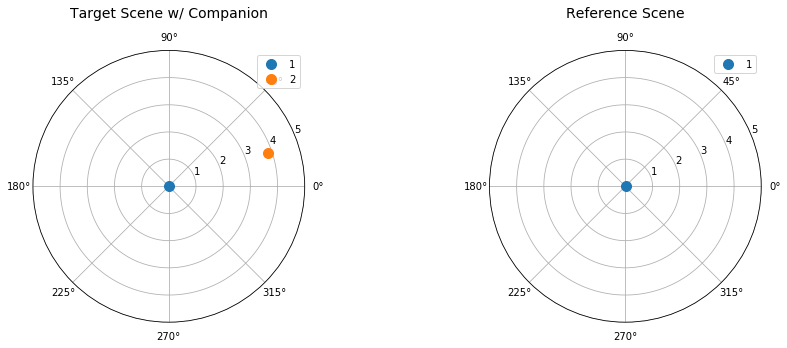

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121,polar=True)
scene.plot_scene(target['scene'],'Target Scene w/ Companion',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)
plt.subplot(122,polar=True)
scene.plot_scene(reference['scene'],'Reference Scene',newfig=False)
ax = plt.gca()
ax.set_rlim(0,5.)

# Run the Pandeia Engine

Now we pass our calculation files to the pandeia engine to create the slope images (and a number of other products).

The most direct way to do so is to pass the calculation file to ```engine.perform_calculation.``` However, because the calculation can be fairly time-consuming, ```engine.calculate_batch``` is provided as a convenience function for easy parallelization.

### Wave Sampling

An aside on performance and accuracy: The ```engine.wave_sampling``` parameter provides a hook into the wavelength sampling of the 3D (x,y,wavelength) cube. By default, Pandeia adopts some large value for the wavelength sampling (typically 150+); however, this is the primary time sink in the calculation. Setting ```engine.wave_sampling = 10``` while developing your simulation provides dramatic time savings while getting within ~5% of the "true" value. By ```engine.wave_sampling = 40```, one can expect agreement to within roughly 1%.

### On-the-fly PSF Calculations

The Pandeia engine relies on a library of precomputed PSFs that are sparsely sampled across the coronagraphic field of view. For the MIRI coronagraphs, this sparse sampling will often be insufficient for accurately capturing PSF variations arising from small offsets.

Pandeia-Coronagraphy gives the option (```engine.on_the_fly_PSFs```) to circumvent the use of this precomputed library and force recomputing each PSF on the fly in WebbPSF. We'll toggle it to True, at the cost of some speed.


In [ ]:
engine.wave_sampling = 20
engine.on_the_fly_PSFs = True
targ_results, ref_results = engine.calculate_batch([target,reference])

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


Plot the detector images (in e$^-$/s)

In [ ]:
target_slope = targ_results['2d']['detector']
reference_slope = ref_results['2d']['detector']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(target_slope)
plt.title('Target Slope Image')
plt.colorbar().set_label('e$^{-}$/s')
plt.subplot(122)
plt.imshow(reference_slope)
plt.title('Reference Slope Image')
plt.colorbar().set_label('e$^{-}$/s')

And check for saturation:

In [ ]:
target_sat = targ_results['2d']['saturation']
reference_sat = ref_results['2d']['saturation']

plt.figure(figsize=(10,4))
plt.subplot(121)
plt.imshow(target_sat)
plt.title('Target Saturation Image')
plt.subplot(122)
plt.imshow(reference_sat)
plt.title('Reference Saturation Image')

# Post-Processing

Subtract the registered and scaled reference PSF from the target image.

In [ ]:
# Handle any NaNs in the image (caused by saturation)
clean_reference[np.isnan(reference_slope)] = np.nanmax(reference_slope)

# Register the reference to the target and renormalize
registered_ref = analysis.register_to_target(clean_reference,target_slope,rescale_reference=True)

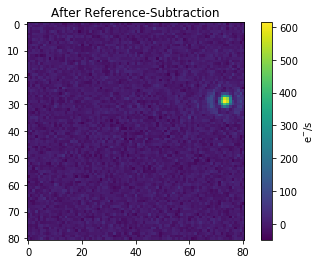

In [47]:
plt.imshow(centered_target - registered_ref)
plt.colorbar().set_label('e$^{-}$/s')
plt.title('After Reference-Subtraction')

# Optimizing Observation Parameters


In [9]:
ngroup_list = range(2,8)

raw_images = []
refsub_images = []
for ngroup in ngroup_list:
    
    #Exposure parameters
    numberofgroups = ngroup
    numberofints = 1
    target['configuration']['detector']['ngroup'] = numberofgroups
    target['configuration']['detector']['nint'] = numberofints
    reference['configuration']['detector']['ngroup'] = numberofgroups
    reference['configuration']['detector']['nint'] = numberofints

    #Pandeia calculation
    engine.wave_sampling = 20
    engine.on_the_fly_PSFs = False # accurately capturing spatial variation is unnecessary for this calculation
    occ_results, ref_results = engine.calculate_batch([target,reference])
    occ_slope = occ_results['2d']['detector']
    ref_slope = ref_results['2d']['detector']

    #PSF subtraction assuming photon noise, the normalization is done properly 
    centered_occ = occ_slope - np.nanmean(occ_slope)
    centered_ref = ref_slope - np.nanmean(ref_slope)
    reg_ref = analysis.register_to_target(centered_ref,centered_occ)
    ref_sub = centered_occ - reg_ref
    
    raw_images.append(centered_occ)
    refsub_images.append(ref_sub)

/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)
/Users/kgorkom/anaconda/envs/pandeia/lib/pyt

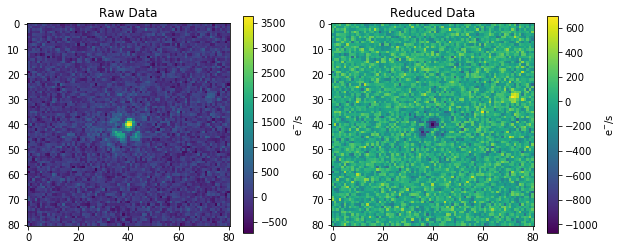

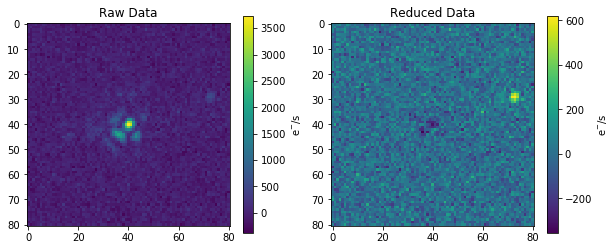

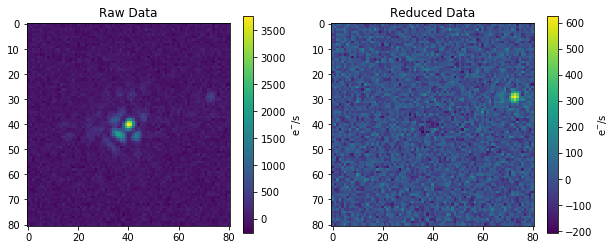

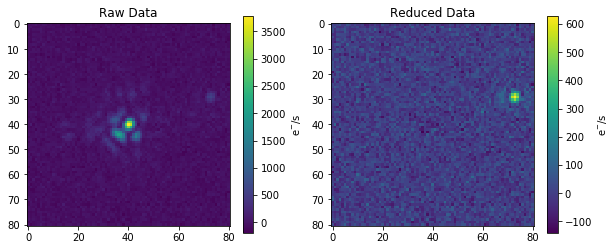

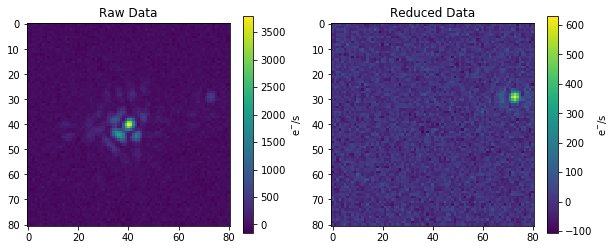

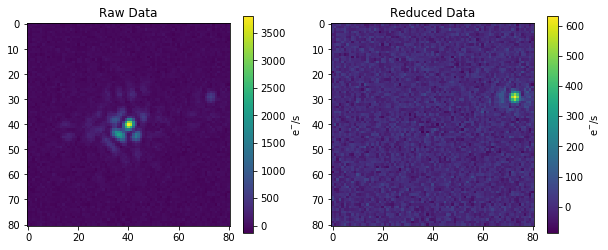

In [10]:
for raw, reduced in zip(raw_images,refsub_images):
    plt.figure(figsize=(10,4))
    plt.subplot(121)
    plt.imshow(raw)
    plt.title('Raw Data')
    plt.colorbar().set_label('e$^{-}$/s')
    plt.subplot(122)
    plt.imshow(reduced)
    plt.title('Reduced Data')
    plt.colorbar().set_label('e$^{-}$/s')

# Save Calculation File

Save out your scene and instrument parameters for quick loading with a future call to ```engine.load_calculation```

In [50]:
engine.save_calculation(target,'mygreatcalculation.json')

# Save Pandeia Images

```engine.save_to_fits``` is provided as a convenience function for quickly saving out arrays or cubes to a FITS file. This doesn't preserve any header values. See http://docs.astropy.org/en/stable/io/fits/ for a more complete treatment of reading and writings FITS files in Python.

In [51]:
# Save out 2d slop images
engine.save_to_fits(targ_results['2d']['detector'],'target_slope.fits')
engine.save_to_fits(ref_results['2d']['detector'],'reference_slope.fits')

# Save out cube
engine.save_to_fits(raw_images,'raw_cube.fits')

# Limiting Contrast Calculation


This is where we calculate the contrast as a function of exposure time. Note that in this example the limiting contrast is driven by:

1. detector noise, in the Pandeia model
2. photon noise on the speckles
3. TA error between target and reference. 

There is no error due to wavefront thermal drifts or dynamical vibrations 

In [11]:
engine.on_the_fly_PSFs = True #re-enable

For the occulted source, we'll copy the target calculation from before and pop the planet out of the scene list.

(0, 1.5)

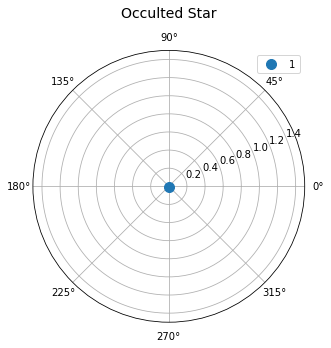

In [12]:
occulted = deepcopy(target)
occulted['scene'].pop(-1)

#and plot
scene.plot_scene(occulted['scene'],'Occulted Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

The unocculted source for the contrast normalization is just the target source moved from behind the coronagraphic mask.

(0, 1.5)

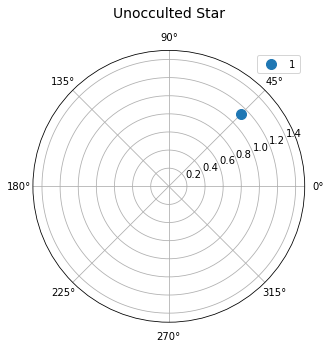

In [13]:
#copy the occulted calculation file
unocculted = deepcopy(occulted)
#apply an offset
unocculted['scene'][0]['position']['x_offset'] = 0.8 # arcsec
unocculted['scene'][0]['position']['y_offset'] = 0.8 # arcsec

unocculted['calculation']['effects']['saturation'] = False # Disable saturation

#and plot
scene.plot_scene(unocculted['scene'],'Unocculted Star')
ax = plt.gca()
ax.set_rlim(0,1.5)

 We'll use the same reference as in the previous calculations.

In [14]:
from scipy.signal import fftconvolve

def quick_contrast(occulted_image,unocculted_image,n_annuli=20):
    '''
    A quick and dirty contrast calculation just for demonstration
    purposes.
    '''
    # Convolve the unocculted image with an aperture and pick out the max 
    # as the normalization constant
    kernel = np.array([[0,0,1,0,0], #simple aperture
                   [0,1,1,1,0],
                   [1,1,1,1,1],
                   [0,1,1,1,0],
                   [0,0,1,0,0]]).astype(float)
    unocc_aperture = fftconvolve(unocculted_image,kernel,mode='valid')
    norm = np.max(unocc_aperture)

    # Convolve reference-subtract and raw frames with the aperture as well
    occ_aperture = fftconvolve(occulted_image,kernel,mode='valid')

    # Compute radial distance from center (in pixels)
    indices = np.indices(unocc_aperture.shape)
    center = np.array(unocc_aperture.shape) / 2.
    radial = np.sqrt( (indices[0] - center[0])**2 + (indices[1] - center[1])**2 )
    # Compute 20 annuli (uniform in radius)
    radial_bins = np.linspace(0,np.max(radial),num=n_annuli)
    annuli_inds = np.digitize(radial,radial_bins)

    # Take the variance of raw and reference-subtracted images in each annulus and normalize by unocculted max
    contrast = np.array([np.std(occ_aperture[annuli_inds == a]) for a in np.unique(annuli_inds)]) / norm    
    return radial_bins, contrast

Now we'll iterate over exposure parameters and calculate the raw and reference-subtracted contrast at each iteration.

NB: In the loop below, you'll notice we've replaced the call ```engine.calculate_batch([occulted,unocculted,reference])``` with three separate calls to ```engine.perform_calculation```. This is motivated by an [LRU cache](https://en.wikipedia.org/wiki/Cache_replacement_policies#Least_Recently_Used_.28LRU.29) implemented to cache the results of calls to WebbPSF to avoid duplicating unecessary calculations. However, this caching implementation is incompatible with multiprocessing, so to take advantage of it, we've serialized the calls to the Pandeia engine. This translates into a substantial times savings for sequential calculations that modify things like exposure time but not source properties or filters (which would require new calculations in WebbPSF).

In [15]:
n_annuli = 30
ngroup_list = range(2,11)

raw_contrast_list = []
refsub_contrast_list = []
for ngroup in ngroup_list:
    # Exposure parameters
    numberofgroups = ngroup
    numberofints = 1
    occulted['configuration']['detector']['ngroup'] = numberofgroups
    occulted['configuration']['detector']['nint'] = numberofints
    unocculted['configuration']['detector']['ngroup'] = 200
    unocculted['configuration']['detector']['nint'] = 10
    reference['configuration']['detector']['ngroup'] = numberofgroups
    reference['configuration']['detector']['nint'] = numberofints

    # Pandeia calculation
    # Here we avoid calculate_batch to take advantage
    # of LRU caching, which is incompatible with
    # multiprocessing.
    occ_results = engine.perform_calculation(occulted)
    unocc_results = engine.perform_calculation(unocculted)
    ref_results = engine.perform_calculation(reference)
    occ_slope = occ_results['2d']['detector']
    unocc_slope = unocc_results['2d']['detector']
    ref_slope = ref_results['2d']['detector']

    # PSF subtraction assuming photon noise, the normalization is done properly 
    centered_occ = occ_slope - np.nanmean(occ_slope)
    centered_ref = ref_slope - np.nanmean(ref_slope)
    reg_ref = analysis.register_to_target(centered_ref,centered_occ)
    ref_sub = centered_occ - reg_ref

    radial_bins, raw_contrast = quick_contrast(occ_slope,unocc_slope,n_annuli=n_annuli)
    radial_bins, refsub_contrast = quick_contrast(ref_sub,unocc_slope,n_annuli=n_annuli)

    raw_contrast_list.append(raw_contrast)
    refsub_contrast_list.append(refsub_contrast)


/Users/kgorkom/anaconda/envs/pandeia/lib/python2.7/site-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


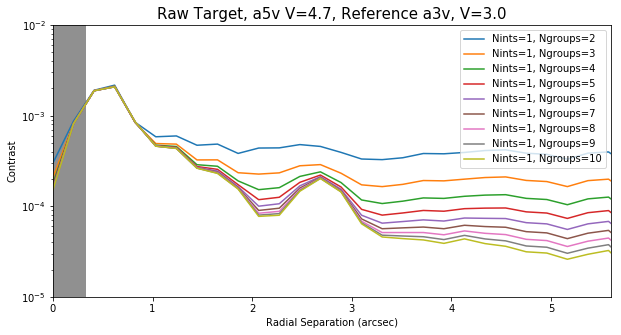

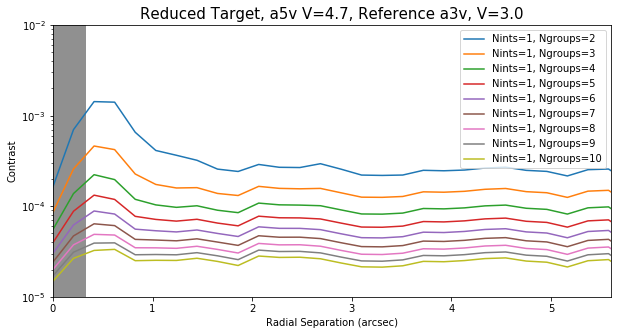

In [16]:
pix_scale = 0.11 # see https://jwst-docs.stsci.edu/display/JTI/MIRI+Coronagraphic+Imaging
mask_radii = 0.33

plt.figure(figsize=(10,5))
for i,contrast in enumerate(raw_contrast_list):
    plt.semilogy(radial_bins * pix_scale,contrast,label='Nints=1, Ngroups={}'.format(ngroup_list[i]))
    plt.fill_between([0,mask_radii],1e-6,20,alpha=0.2,lw=0,color=[0.5,0.5,0.5])
    plt.xlabel('Radial Separation (arcsec)')
    plt.ylabel('Contrast')
    plt.xlim(0,5.6)
    plt.ylim(1e-5,1e-2)
    plt.title('Raw Target, {} V={}, Reference {}, V={}'.format(target_Sp,target_mV,ref_Sp,ref_mV),fontsize=15)
    plt.legend(loc='upper right')
    
plt.figure(figsize=(10,5))
for i,contrast in enumerate(refsub_contrast_list):
    plt.semilogy(radial_bins * pix_scale,contrast,label='Nints=1, Ngroups={}'.format(ngroup_list[i]))
    plt.fill_between([0,mask_radii],1e-6,20,alpha=0.2,lw=0,color=[0.5,0.5,0.5])
    plt.xlabel('Radial Separation (arcsec)')
    plt.ylabel('Contrast')
    plt.xlim(0,5.6)
    plt.ylim(1e-5,1e-2)
    plt.title('Reduced Target, {} V={}, Reference {}, V={}'.format(target_Sp,target_mV,ref_Sp,ref_mV),fontsize=15)
    plt.legend(loc='upper right')
    